In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import math

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
import calendar
# 
air = pd.read_csv('air_visit_data.csv', parse_dates=[1])
air.set_index(['visit_date'], inplace=True)
air.index.name=None
air.drop('air_store_id',axis=1,inplace=True)
df2=pd.DataFrame()
df2['visit_total'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].sum()
df2['visit_mean'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].mean()
df2['reserv_cnt'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].count()
air=df2;del df2

#Get the date info with dow and holidays
hol=pd.read_csv('date_info.csv', parse_dates=True).rename(columns={'calendar_date':'visit_date'})
hol['visit_date'] = pd.to_datetime(hol['visit_date'])
hol.set_index(['visit_date'], inplace=True)
hol.index.name=None
hol.day_of_week = hol.day_of_week.apply(list(calendar.day_name).index)

#Get the test submission
test = pd.read_csv('sample_submission.csv')
test['store_id'], test['visit_date'] = test['id'].str[:20], test['id'].str[21:]
test.set_index('visit_date', drop=True, inplace=True)
test.index.name=None

In [4]:
def rmsle(y_pred, y_test) : 
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

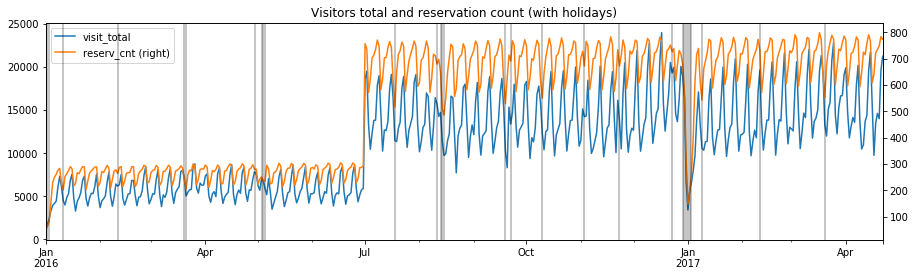

In [5]:
air['visit_total'].plot(legend=True);
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True,
                      title='Visitors total and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

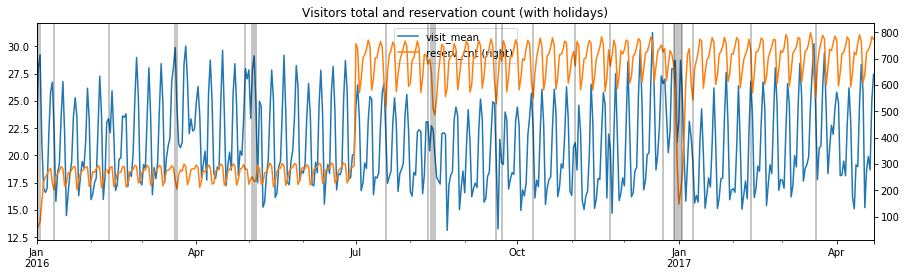

In [6]:
air['visit_mean'].plot(figsize=(15,4), legend=True, title='Visitors mean (with holidays)')
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True, title='Visitors total and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

<Figure size 432x288 with 0 Axes>

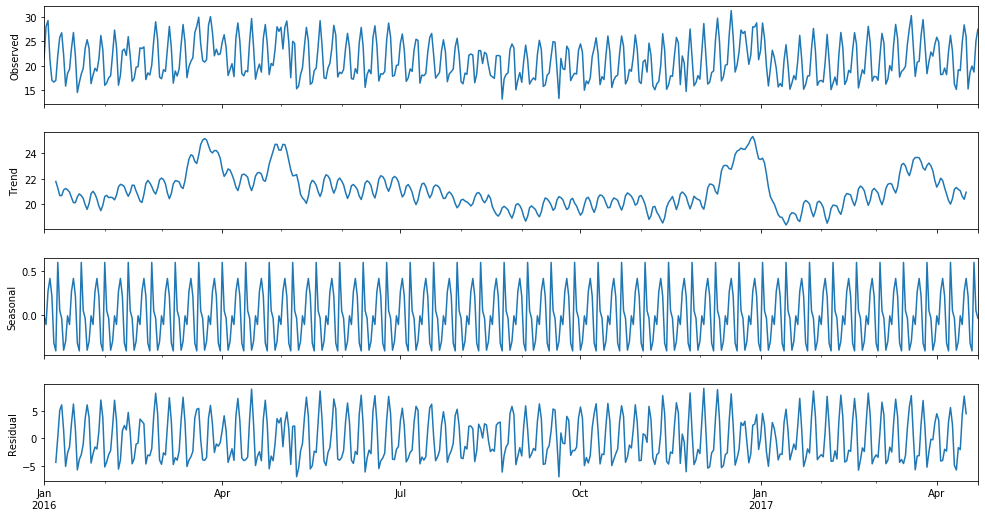

In [7]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(air.visit_mean, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [8]:
df2=air.join(hol)
df2[df2.holiday_flg==0].groupby(hol.day_of_week,squeeze=True,sort=True)['visit_mean'].sum()
#df2.day_of_week=df3.day_of_week.apply(lambda x: list(calendar.day_name)[x]) # equiv to air.sum(0)

day_of_week
0     990.358277
1    1166.228003
2    1265.651637
3    1162.836395
4    1503.191793
5    1731.514759
6    1534.474447
Name: visit_mean, dtype: float64

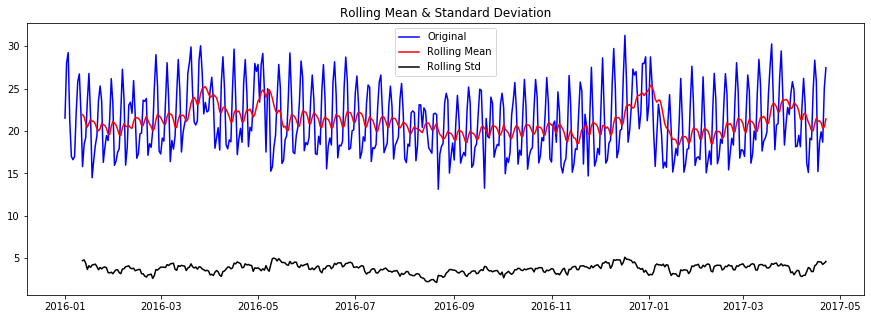

Results of Dickey-Fuller Test:
Test Statistic                  -3.796104
p-value                          0.002947
#Lags Used                      16.000000
Number of Observations Used    461.000000
Critical Value (1%)             -3.444615
Critical Value (5%)             -2.867830
Critical Value (10%)            -2.570120
dtype: float64


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


'test_stationarity(air.visit_mean_log) #-3.830754'

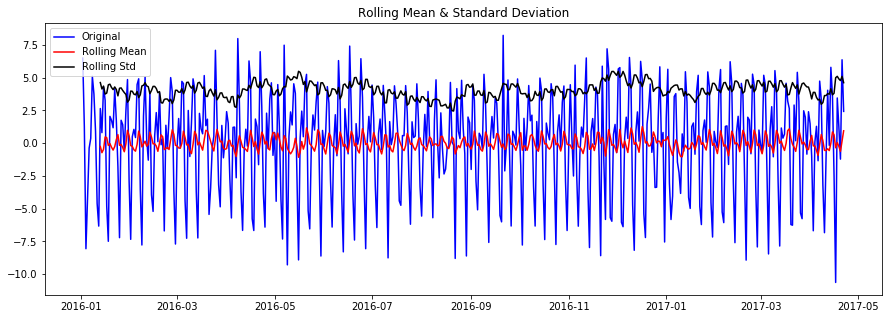

Results of Dickey-Fuller Test:
Test Statistic                -6.608968e+00
p-value                        6.448883e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.580000e+02
Critical Value (1%)           -3.444709e+00
Critical Value (5%)           -2.867871e+00
Critical Value (10%)          -2.570142e+00
dtype: float64


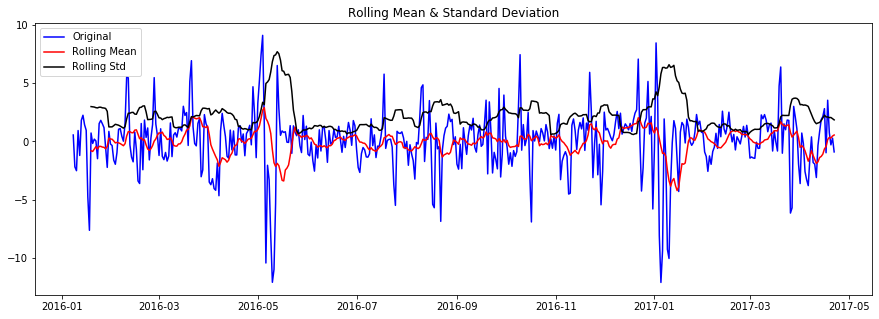

Results of Dickey-Fuller Test:
Test Statistic                -7.196314e+00
p-value                        2.429479e-10
#Lags Used                     1.500000e+01
Number of Observations Used    4.550000e+02
Critical Value (1%)           -3.444804e+00
Critical Value (5%)           -2.867913e+00
Critical Value (10%)          -2.570165e+00
dtype: float64


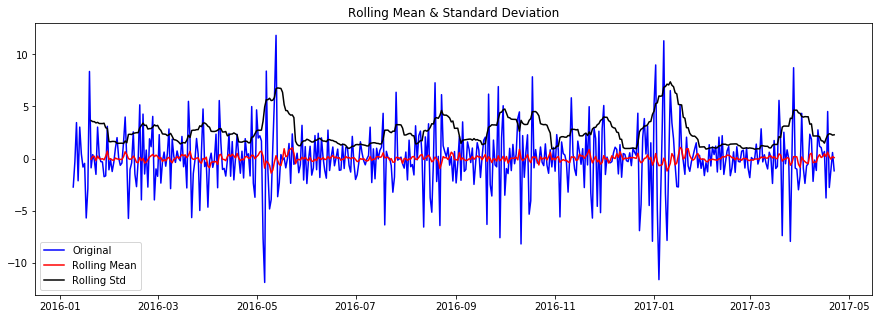

Results of Dickey-Fuller Test:
Test Statistic                -9.427797e+00
p-value                        5.288819e-16
#Lags Used                     1.600000e+01
Number of Observations Used    4.530000e+02
Critical Value (1%)           -3.444868e+00
Critical Value (5%)           -2.867941e+00
Critical Value (10%)          -2.570180e+00
dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean();
    rolstd = timeseries.rolling(window=12,center=False).std();

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(air.visit_mean); #-3.796104
# Log is a minor improvement, meaning that the variance is stable
air.visit_mean_log= air.visit_mean.apply(lambda x: np.log(x))  
'''test_stationarity(air.visit_mean_log) #-3.830754'''
# Although I see no real global trend, 1st difference strongly improves stationarity
air['visit_mean_diff'] = air.visit_mean - air.visit_mean.shift(1)  
test_stationarity(air.visit_mean_diff.dropna(inplace=False)) #-6.608968e+00
# Seasonal difference: take a weekly season improves stationarity even more
air['visit_mean_seasonal'] = air.visit_mean - air.visit_mean.shift(7)
test_stationarity(air.visit_mean_seasonal.dropna(inplace=False)) #-7.196314e+00
# Seasonal and 1st difference is even better, but we were already well within the 1% confidence interval
air['visit_mean_seasonal_diff'] = air.visit_mean_diff - air.visit_mean_diff.shift(7)
test_stationarity(air.visit_mean_seasonal_diff.dropna(inplace=False)) #-9.427797e+00

ACF and PACF of the visit mean:


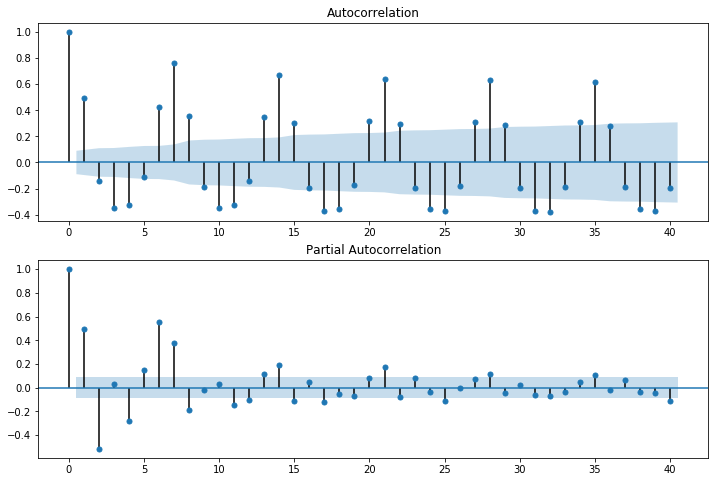

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean, lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(air.visit_mean, lags=40, alpha=.05, ax=ax2)
print("ACF and PACF of the visit mean:")

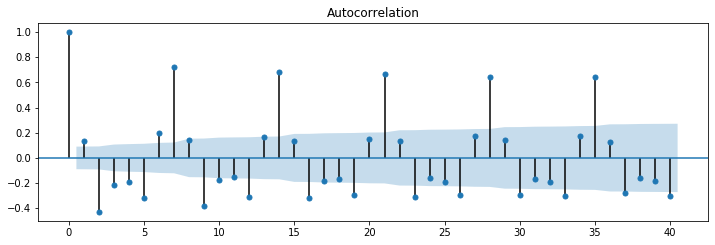

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean_diff[1:], lags=40, alpha=.05, ax=ax1)

ACF and PACF of the 7-day differenced visit mean:


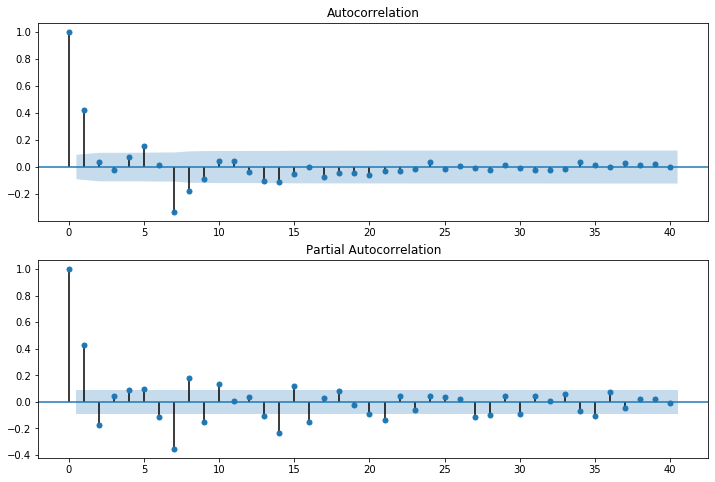

In [12]:
print("ACF and PACF of the 7-day differenced visit mean:")
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean_seasonal[8:], lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(air.visit_mean_seasonal[8:], lags=40, alpha=.05, ax=ax2)

In [13]:
from sklearn.metrics import mean_squared_error
def mean_squared_log_error(y_pred, y_true, **dict):
    '''Assume y_true starts earlier than y_pred, y_true is NaN free, and NaN in y_pred are only in the beginning'''
    indafterNaN = y_pred.first_valid_index()
    if (y_true.index[0] > y_pred.index[0]): return "Check indices of prediction and true value"
    ind1stcommon = y_true.index[y_true.index==y_pred.index[0]]
    indstart = max(indafterNaN, ind1stcommon)
    indend = y_true.index[-1]
    return mean_squared_error(np.log(y_true[indstart:indend]+1), 
                              np.log(y_pred[indstart:indend]+1) )**0.5

def plotSARIMAX(labels, pred):
    fig = plt.figure(figsize=(12, 8))
    layout = (2, 2)
    ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax3 = plt.subplot2grid(layout, (1, 0))
    ax4 = plt.subplot2grid(layout, (1, 1))
    labels.plot(ax=ax1);
    pred.plot(ax=ax1, title='RMSLE: %.4f'% rmsle(pred, labels))
    ax3 = sm.graphics.tsa.plot_acf(results.resid, lags=40, alpha=.05, ax=ax3, title="ACF of residuals")
    ax4 = sm.graphics.tsa.plot_pacf(results.resid, lags=40, alpha=.05, ax=ax4, title="PACF of residuals")
    plt.tight_layout()
    print("ACF and PACF of residuals")

In [14]:
from scipy.optimize import brute
from sklearn.metrics import mean_squared_error

def autoSARIMAX(endog, exog=None, date_train_end=None, pred_days=[-12,12], verbose=True,\
        ranges=(slice(1,3),slice(0,1),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8))):
    #Instantiate my version of the grid with parameters and scores
    global grid
    grid = []
    #Get indices up to which you do train and prediction 
    if date_train_end is None:
        ind_train = endog.index[-1]
    else:
        ind_train = np.where(endog.index==date_train_end)[0][0]
    #Brute optimization
    resultsbrute = brute(runSARIMAX, ranges=ranges, args=(endog,exog,(ind_train,pred_days),), full_output=True, finish=None)
    #First coefficients run two times for some reason or another
    del grid[0]
    #Print/Plot results
    if verbose:
        print("Best parameters: {}".format([int(p) for p in resultsbrute[0]]))
        print("Best score:          {}".format(resultsbrute[1]))
        gr = plotautoSARIMAX(resultsbrute, verbose)
    return resultsbrute, gr

def plotautoSARIMAX(resultsbrute, verbose=True):
    #Print/Plot results
    if not verbose: return None
    #Plot scores by parameter values
    gr = pd.DataFrame({'params':[''.join(str(n) for n in g[0]) for g in grid], 'score': [row[1] for row in grid], 'aic': [row[2] for row in grid]})
    print("All parameters and scores: \n")
    print(gr.head(1000).to_string())
    ax1 = gr.plot('params','score',rot=90, grid=True, figsize=(15,4))
    ax2 = gr.plot('params','aic',rot=90, secondary_y=True,ax=ax1)
    ax1.set_ylabel('Score');ax2.set_ylabel('AIC');
    plt.xticks(range(len(gr)), gr.params, rotation=90);
    return gr

def runSARIMAX(coeffs, *args):
    endog = args[0]
    exog = args[1]
    #Process the row indices for training and prediction
    ind_train = args[2][0]
    pred_days = args[2][1]
    ind_pred = [len(endog)+pred_days[0], len(endog)+pred_days[1]]
    if ind_pred[0] > ind_train: 
        #ind_pred[0]=ind_train
        raise ValueError('Make sure prediction bounds begin at least at len(endog): pred_days[0] must be <= %i ' % (ind_train-len(endog)))
    exog_train, exog_pred, start_params = None, None, list()
    if exog is not None:
        if ind_pred[1] > len(exog):
            raise ValueError('Make sure prediction bounds end  <= len(exog): pred_days[1] must be <= %i ' % (len(exog)-len(endog)))
        exog_train = exog[:ind_train]
        exog_cols = 1 if len(exog.shape) == 1 else exog.shape[1]
        start_params.extend(0.1*np.ones(exog_cols-1))
        exog_pred = exog[ind_pred[0]-1:ind_pred[1]]
        exog_pred = pd.DataFrame(exog_pred)
        
    #Get the hyperparameters
    order = coeffs[0:3].tolist()
    seasonal_order = coeffs[3:7].tolist()
    trend = 'c' if (order[1]==0) else 'n'
    #Train SARIMAX and fit it on data, predict to get scores
    try:        
        mod = sm.tsa.statespace.SARIMAX(endog[:ind_train], exog_train, \
                                        trend=trend, order=order, seasonal_order=seasonal_order)
        start_params.extend(0.1*np.ones( len(mod.params_complete)))
        fit = mod.fit(start_params=start_params)
        pred = fit.predict(start=ind_pred[0], end=ind_pred[1], exog=exog_pred)
        aic = fit.aic
        score = mean_squared_log_error(pred[:-pred_days[0]], endog[ind_pred[0]:])        
        if np.isnan(aic): aic, score = np.inf, np.inf
    except:  #Tip: Try to set starting paramenters in .fit()
        import sys        
        print("Error:", sys.exc_info())        
        print("{},{},'{}', len(start_params)={}\n".format(coeffs[0:3], coeffs[3:], trend, len(start_params)))
        aic, score = np.inf, np.inf
    #Sorry but I don't like the grid in the output of brute resultsbrute[2]
    global grid
    grid.append([coeffs,score,aic])
    return score

#Quick example
#resbrute, gr = autoSARIMAX(endog=air.visit_mean, exog=None, date_train_end="2017-03-26", pred_days=[-28,66],\
#                             ranges=(slice(1,2),slice(0,1),slice(1,2),  slice(0,2),slice(1,2),slice(1,2),slice(7,8)))

#resbrute, gr=autoSARIMAX(endog=air.visit_mean, exog=hol.holiday_flg, date_train_end="2017-03-26", pred_days = [-28,39],\
#                    ranges=(slice(1,2),slice(0,1),slice(1,2),  slice(0,1),slice(1,2),slice(1,2),slice(7,8)))

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\u

Best parameters: [1, 0, 2, 0, 1, 1, 7]
Best score:          0.06993851501449562
All parameters and scores: 

     params     score          aic
0   1011117  0.075008  1847.452060
1   1020117  0.069939  1837.934574
2   1021117  0.070532  1832.519424
3   1110117  0.092015  1872.663521
4   1111117  0.089551  1861.546491
5   1120117  0.101328  1845.481859
6   1121117  0.103014  1839.896161
7   2010117  0.077761  1861.588405
8   2011117  0.074784  1847.328066
9   2020117  0.070065  1837.873846
10  2021117  0.071464  1832.308179
11  2110117  0.115145  1838.895736
12  2111117  0.119443  1835.609464
13  2120117  0.115618  1838.887054
14  2121117  0.118134  1835.559968


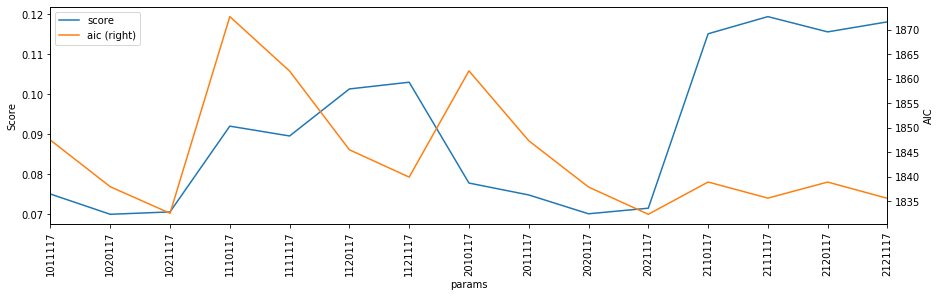

In [15]:
resbrute, gr = autoSARIMAX(endog=air.visit_mean, exog=None, date_train_end="2017-03-26", pred_days = [-28,39],\
                             ranges=(slice(1,3),slice(0,2),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8)))
#Not shown, but the SMA parameter is important to keep to 1

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                        visit_mean   No. Observations:                  450
Model:             SARIMAX(1, 0, 2)x(1, 1, 1, 7)   Log Likelihood                -907.244
Date:                           Tue, 17 Dec 2019   AIC                           1828.488
Time:                                   09:09:26   BIC                           1857.143
Sample:                               01-01-2016   HQIC                          1839.789
                                    - 03-25-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.001     -0.349      0.727      -0.003       0.002
ar.L1          0.9448      0.030     31.319

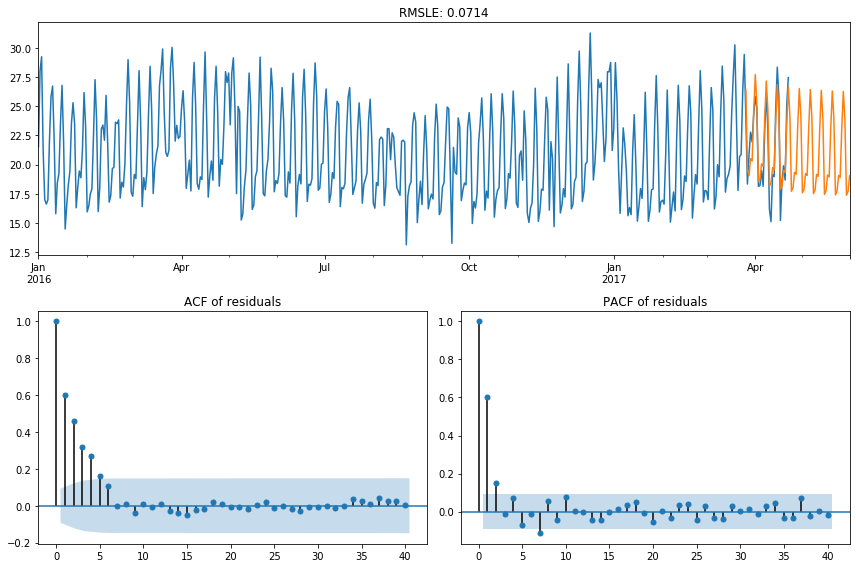

In [16]:
mod = sm.tsa.statespace.SARIMAX(air.visit_mean[:450], trend='c', order=(1,0,2), seasonal_order=(1,1,1,7))
results = mod.fit()
#Predict on future data and on time periods already known for evaluation with RMSLE
pred = results.predict(start=450, end=516)
print(results.summary())
#Plot
plotSARIMAX(air.visit_mean, pred)

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Best parameters: [2, 0, 2, 1, 1, 1, 7]
Best score:          0.0672984268111798
All parameters and scores: 

     params     score          aic
0   1011117  0.075154  1764.629219
1   1020117  0.074824  1760.405179
2   1021117  0.071316  1748.431663
3   1110117  0.090513  1782.025640
4   1111117  0.092131  1765.454576
5   1120117  0.096079  1765.083559
6   1121117  0.099321  1752.677621
7   2010117  0.080271  1788.370301
8   2011117  0.074957  1764.506072
9   2020117  0.077075  1759.799935
10  2021117  0.067298  1751.490064
11  2110117  0.105431  1755.585128
12  2111117  0.110060  1747.055584
13  2120117  0.116733  1747.927542
14  2121117  0.118996  1744.319871


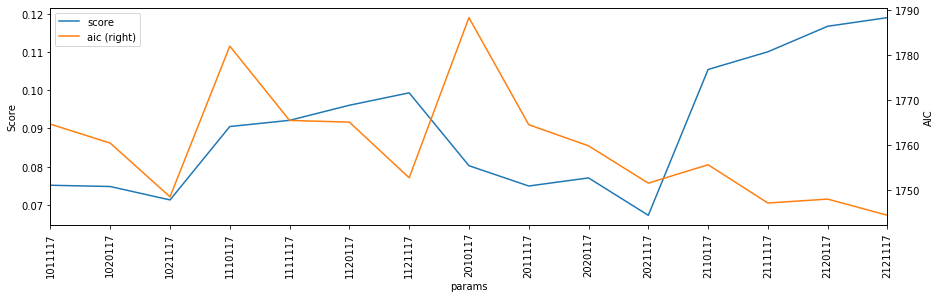

In [17]:
resbrute, gr=autoSARIMAX(endog=air.visit_mean, exog=hol.holiday_flg, date_train_end="2017-03-26", pred_days=[-28,39],\
                    ranges=(slice(1,3),slice(0,2),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8)))

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ACF and PACF of residuals


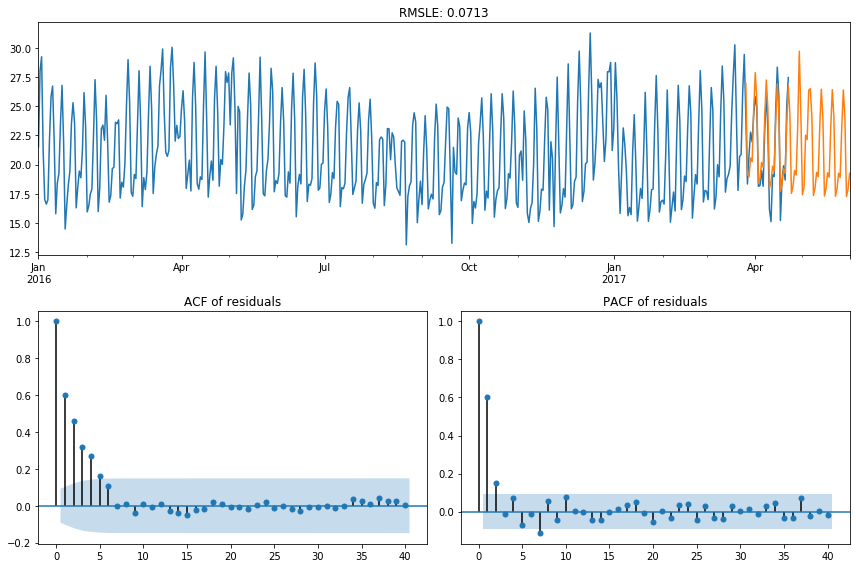

In [18]:
modx = sm.tsa.statespace.SARIMAX(air.visit_mean[:450], trend='c', exog=hol.holiday_flg[:450],\
                                 order=(1,0,2), seasonal_order=(1,1,1,7))
resultsx = modx.fit(start_params=0.1*np.ones( len(modx.param_terms)-2+ 2*2 ))
#Predict on future data and on time periods already known for evaluation with RMSLE
predx = resultsx.predict(start=450, end=516, exog=pd.DataFrame(hol.holiday_flg[450:]))
plotSARIMAX(air.visit_mean, predx)

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Best parameters: [1, 0, 2, 1, 1, 1, 7]
Best score:          0.07262687773922726
All parameters and scores: 

     params     score          aic
0   1011117  0.079299  1766.627119
1   1020117  0.078348  1762.364972
2   1021117  0.072627  1750.396331
3   1110117  0.094375  1784.026100
4   1111117  0.096090  1767.454000
5   1120117  0.099730  1767.083646
6   1121117  0.103097  1754.677965
7   2010117  0.083564  1790.370493
8   2011117  0.079024  1766.505363
9   2020117  0.076298  1761.863497
10  2021117  0.076652  1749.328908
11  2110117  0.108780  1757.585048
12  2111117  0.113403  1749.055091
13  2120117  0.119837  1749.927707
14  2121117  0.122087  1746.319331


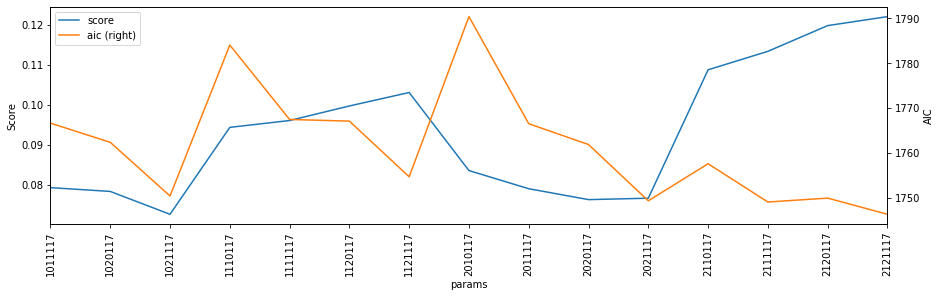

In [19]:
resbrute, gr = autoSARIMAX(endog=air.visit_mean, exog=hol, date_train_end="2017-03-26", pred_days=[-28,39],\
                    ranges=(slice(1,3),slice(0,2),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8)))

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                        visit_mean   No. Observations:                  450
Model:             SARIMAX(1, 0, 2)x(1, 1, 1, 7)   Log Likelihood                -865.198
Date:                           Tue, 17 Dec 2019   AIC                           1748.396
Time:                                   09:10:41   BIC                           1785.238
Sample:                               01-01-2016   HQIC                          1762.927
                                    - 03-25-2017                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0004      0.001     -0.370      0.711      -0.002       0.002
day_of_week     0.1000   5.24e-07   1.91

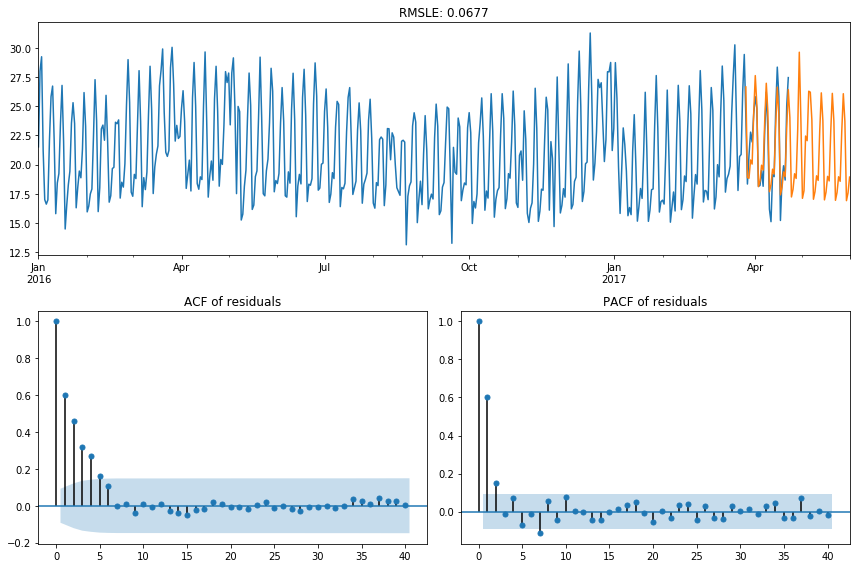

In [20]:
modx2 = sm.tsa.statespace.SARIMAX(air.visit_mean[:450], trend='c', exog=hol[:450], order=(1,0,2), seasonal_order=(1,1,1,7))
resultsx2 = modx2.fit(start_params=0.1*np.ones( len(modx2.params_complete)))
#Predict on future data and on time periods already known for evaluation with RMSLE
predx2 = resultsx2.predict(start=450, end=516, exog=hol[450:])
print(resultsx2.summary())
plotSARIMAX(air.visit_mean,predx2)

In [22]:
print(predx2)

2017-03-26    26.648520
2017-03-27    18.885104
2017-03-28    18.833220
2017-03-29    20.395623
2017-03-30    20.044785
                ...    
2017-05-27    26.069553
2017-05-28    23.694955
2017-05-29    16.913579
2017-05-30    17.580352
2017-05-31    18.933343
Freq: D, Length: 67, dtype: float64
